# Прогнозирование стоимости подержанного автомобиля в Москве

### Постановка задачи

Идеей проекта является построение модели, которую можно использовать для оценки стоимости подержанного автомобиля. 

Для маркетплейсов по продаже автомобилей такая модель могла бы лечь в основу рекомендательной системы при размещении объявлений, а рядовые автомобилисты могли бы использовать эту модель для оценки остаточной стоимости автомобиля и выбора наиболее благоприятного момента для продажи.

### Оглавление

- Импорт библиотек
- Загрузка набора данных и первый взгляд
- Описание набора данных
- Подготовка данных для визуализации
- Визуальный анализ данных
- Закономерности, особенности данных
- Выбор метрики
- Предобработка данных для тренировки модели
- Baselines
- Feature Engineering
- Кривые валидации
- Подбор  гиперпараметров
- Оценка модели
- Выводы




## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, KFold, cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
import warnings


In [2]:
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.2)
pd.set_option('precision', 2)
plt.rcParams['figure.figsize'] = (15, 8)
warnings.filterwarnings('ignore')
RANDOM_SEED = 17

## Загрузка набора данных и первый взгляд

In [3]:
df = pd.read_csv('../Auto.ru Car Price Prediction/auto_ru_df.csv', index_col=False,
                 names = ['car_description','year', 'engine', 'power', 'gas', 'transmission', \
                          'body', 'drive', 'color','mileage', 'price'])

In [4]:
df.head()

,car_description,year,engine,power,gas,transmission,body,drive,color,mileage,price
0,LADA () 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,100 000 км,21 000 ₽
1,LADA () 2104 5-speed,1990,1.5,72,Бензин,механика,универсал 5 дв.,задний,красный,91 000 км,99 000 ₽
2,LADA () 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,32 000 км,80 000 ₽
3,LADA () 2107,1990,1.3,64,Бензин,механика,седан,задний,красный,250 000 км,45 000 ₽
4,LADA () 2106,1990,1.3,64,Бензин,механика,седан,задний,голубой,68 000 км,28 000 ₽


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114106 entries, 0 to 114105
Data columns (total 11 columns):
car_description    114106 non-null object
year               114106 non-null int64
engine             114106 non-null float64
power              114106 non-null int64
gas                114106 non-null object
transmission       114106 non-null object
body               114105 non-null object
drive              114105 non-null object
color              114105 non-null object
mileage            114105 non-null object
price              114105 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 9.6+ MB


Удаляем запись с пропущенными значениями

In [6]:
df.dropna(how = 'any', inplace = True)

Удаляем лишнее из колонок

In [7]:
df['car_description'] = df['car_description'].astype('str').str.replace(r'\(\)','')
df['gas'] = df['gas'].str.replace('\s+','')
df['price'] = df['price'].str.replace('\s+','').str.replace('₽', '')
df['mileage'] = df['mileage'].str.replace('\s+', '').str.replace('км', '')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114105 entries, 0 to 114104
Data columns (total 11 columns):
car_description    114105 non-null object
year               114105 non-null int64
engine             114105 non-null float64
power              114105 non-null int64
gas                114105 non-null object
transmission       114105 non-null object
body               114105 non-null object
drive              114105 non-null object
color              114105 non-null object
mileage            114105 non-null object
price              114105 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 10.4+ MB


Приводим пробег и цену к числовому типу

In [8]:
df['mileage'] = df['mileage'].astype('int32')
df['price'] = df['price'].astype('int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114105 entries, 0 to 114104
Data columns (total 11 columns):
car_description    114105 non-null object
year               114105 non-null int64
engine             114105 non-null float64
power              114105 non-null int64
gas                114105 non-null object
transmission       114105 non-null object
body               114105 non-null object
drive              114105 non-null object
color              114105 non-null object
mileage            114105 non-null int32
price              114105 non-null int32
dtypes: float64(1), int32(2), int64(2), object(6)
memory usage: 9.6+ MB


In [9]:
df.describe()

,year,engine,power,mileage,price
count,114105.00,114105.00,114105.00,114105.00,1.14e+05
mean,2009.22,2.22,160.17,143259.07,7.52e+05
std,5.68,2.48,79.57,87023.87,9.38e+05
min,1990.00,0.70,29.00,1.00,1.50e+04
25%,2006.00,1.60,106.00,84000.00,2.80e+05
50%,2010.00,2.00,141.00,130000.00,5.15e+05
75%,2013.00,2.50,184.00,188000.00,8.90e+05
max,2018.00,170.00,717.00,1000000.00,8.89e+07


Максимальный объем двигателя в 170 литров выглядит подозрительно, вероятно, люди опечатывались или путали с другими единицами измерения.Подрежем на разумном значении.

In [10]:
def cutter(x):
    if x < 10:
        return x
    else:
        return x / 100
    
    
df['engine'] = df['engine'].apply(cutter)
df.describe()

,year,engine,power,mileage,price
count,114105.00,114105.00,114105.00,114105.00,1.14e+05
mean,2009.22,2.18,160.17,143259.07,7.52e+05
std,5.68,0.88,79.57,87023.87,9.38e+05
min,1990.00,0.67,29.00,1.00,1.50e+04
25%,2006.00,1.60,106.00,84000.00,2.80e+05
50%,2010.00,2.00,141.00,130000.00,5.15e+05
75%,2013.00,2.50,184.00,188000.00,8.90e+05
max,2018.00,8.40,717.00,1000000.00,8.89e+07


In [11]:
df.head()

,car_description,year,engine,power,gas,transmission,body,drive,color,mileage,price
0,LADA 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,100000,21000
1,LADA 2104 5-speed,1990,1.5,72,Бензин,механика,универсал 5 дв.,задний,красный,91000,99000
2,LADA 2106,1990,1.3,64,Бензин,механика,седан,задний,бежевый,32000,80000
3,LADA 2107,1990,1.3,64,Бензин,механика,седан,задний,красный,250000,45000
4,LADA 2106,1990,1.3,64,Бензин,механика,седан,задний,голубой,68000,28000


In [12]:
df.duplicated().value_counts()

False    113154
True        951
dtype: int64

Удаляем одинаковые записи

In [13]:
df.drop_duplicates(inplace = True)
df.duplicated().value_counts()

False    113154
dtype: int64

In [14]:
df.shape

(113154, 11)

## Описание набора данных

Датасет был получен с помощью скрипта web_scraper.py, который находится в этой же директории. Получение html-страницы сделано с помощью библиотеки Selenium, парсинг осуществлен через библиотеку BeautifulSoup. Парсились объявления с сайта auto.ru в категории подержанные автомобили, территориально расположенные в Москве и 200-километровой окружности.

Набор данных содержит в себе 113154 запись и 11 признаков: 4 числовых, 6 категориальных и целевой.

* car_description - марка, модель и поколение автомобиля
* year - год выпуска
* engine - объем двигателя в литрах
* power - мощность двигателя в лошадиных силах
* gas - типа используемого топлива
* transmission - тип коробки передач
* body -  форма кузова
* drive - привод
* color - цвет кузова
* mileage - пробег
* price - цена



## Подготовка данных для визуализации

Удаляем вторую часть названия производителя "Land Rover", чтобы правильно извлечь названия модели

In [15]:
df['car_description'] = df['car_description'].astype('str').str.replace('Rover','')

Вытаскиваем полезную информацию из столбца "car_description" и удаляем его

In [16]:
manufacturer = df['car_description'].apply(lambda x : x.split()[0])
model = df['car_description'].apply(lambda x : x.split()[1])
restyling = df['car_description'].str.contains('Рестайлинг').astype('int32')
df.insert(0, 'manufacturer', manufacturer)
df.insert(1, 'model', model)
df.insert(2, 'restyling', restyling)
df.drop('car_description', axis = 1, inplace = True);

In [17]:
df['manufacturer'] = df['manufacturer'].str.replace('Land','Land Rover')

In [18]:
df.head()

,manufacturer,model,restyling,year,engine,power,gas,transmission,body,drive,color,mileage,price
0,LADA,2106,0,1990,1.3,64,Бензин,механика,седан,задний,бежевый,100000,21000
1,LADA,2104,0,1990,1.5,72,Бензин,механика,универсал 5 дв.,задний,красный,91000,99000
2,LADA,2106,0,1990,1.3,64,Бензин,механика,седан,задний,бежевый,32000,80000
3,LADA,2107,0,1990,1.3,64,Бензин,механика,седан,задний,красный,250000,45000
4,LADA,2106,0,1990,1.3,64,Бензин,механика,седан,задний,голубой,68000,28000


##  Визуальный анализ данных

### Распределение целевого признака

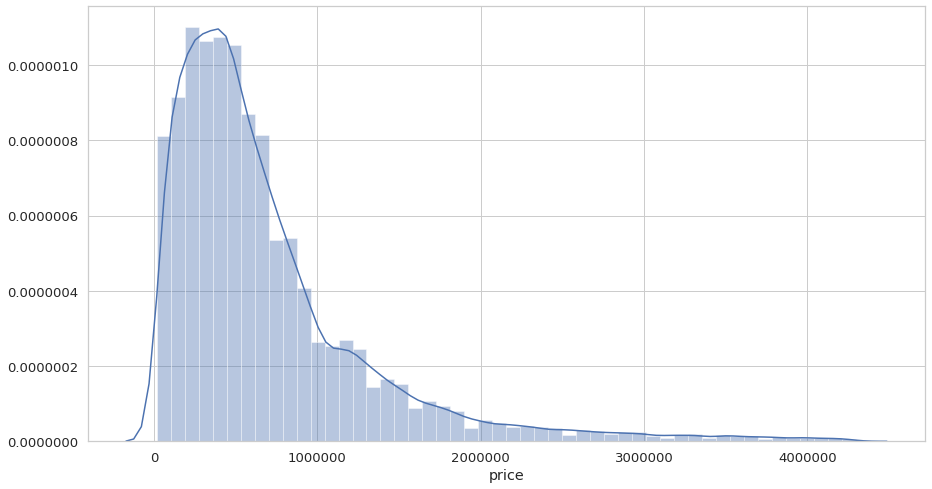

In [19]:
sns.distplot(df[(df['price']<df['price'].quantile(.99))]['price']);

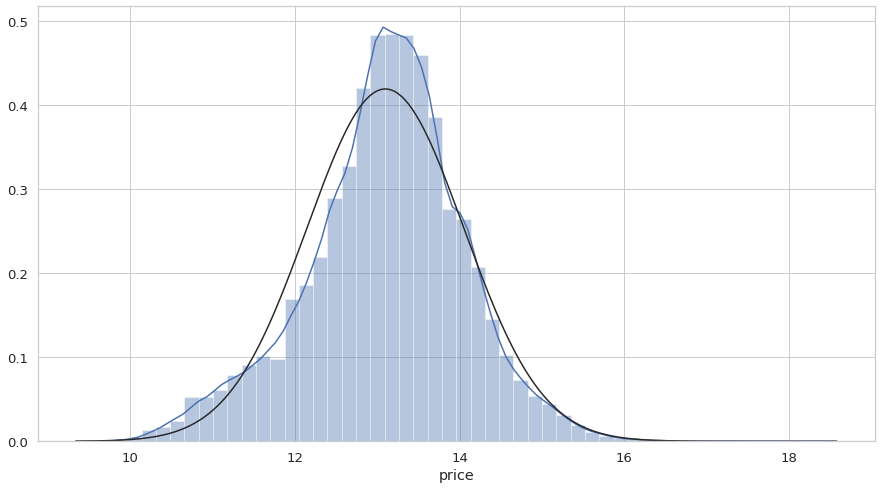

In [20]:
sns.distplot(df['price'].map(np.log), fit=st.norm);

### Распределения наблюдений по категориям

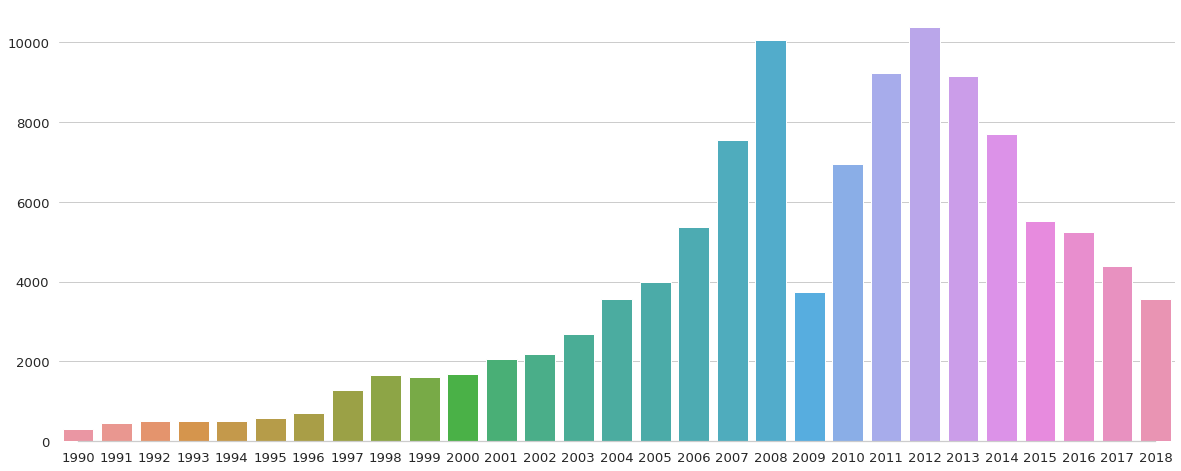

In [21]:
f, ax = plt.subplots(figsize=(20,8))
sns.countplot(x='year', data=df);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

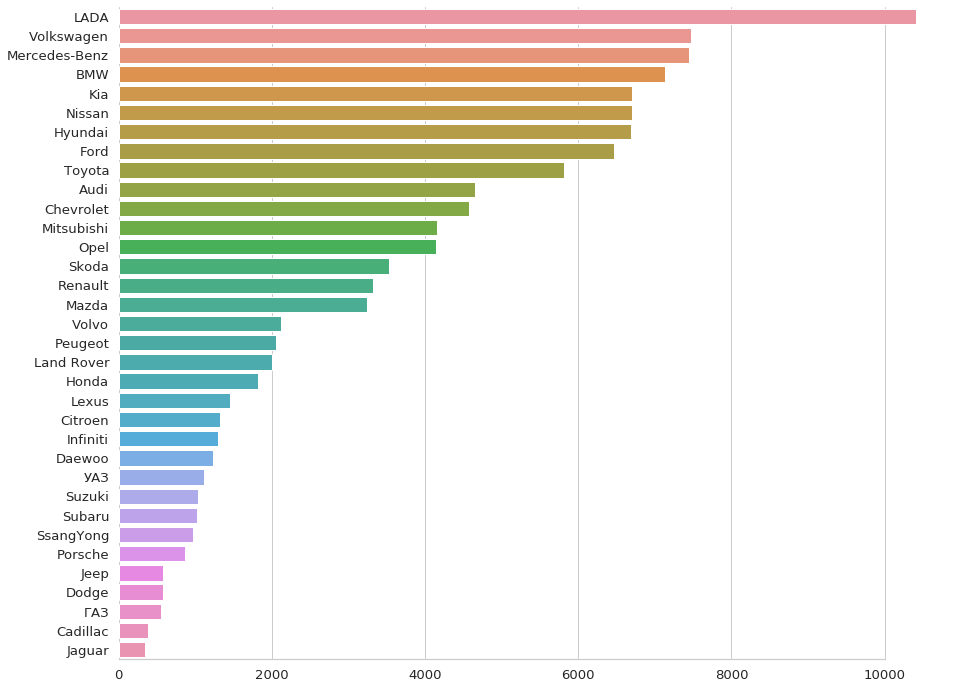

In [22]:
f, ax = plt.subplots(figsize=(15,12))
sns.countplot(y='manufacturer', data=df, order=df['manufacturer'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

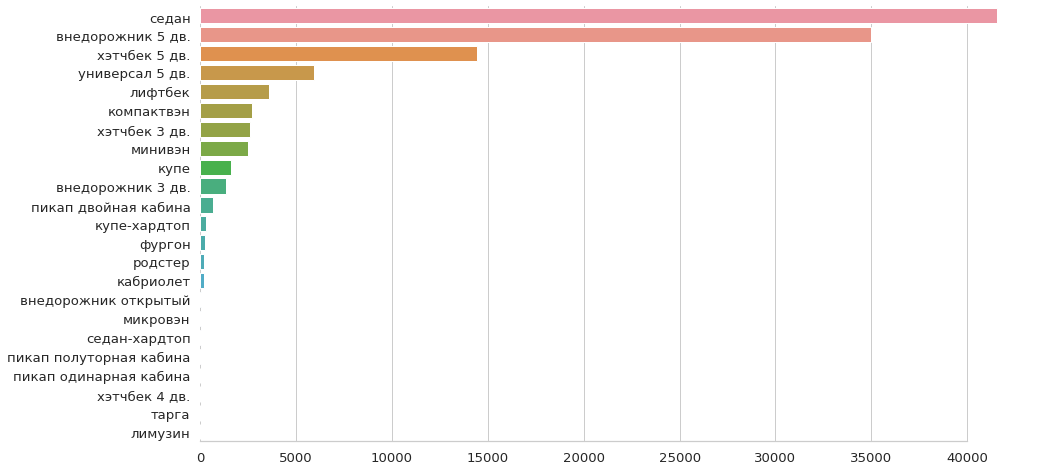

In [23]:
f, ax = plt.subplots(figsize=(15,8))
sns.countplot(y=df['body'], data=df, order=df['body'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

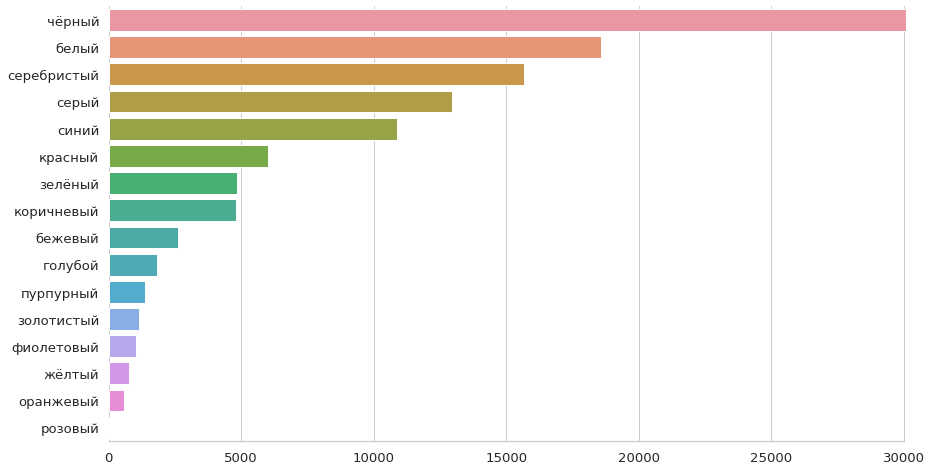

In [24]:
f, ax = plt.subplots(figsize=(15,8))
sns.countplot(y=df['color'], data=df, order=df['color'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

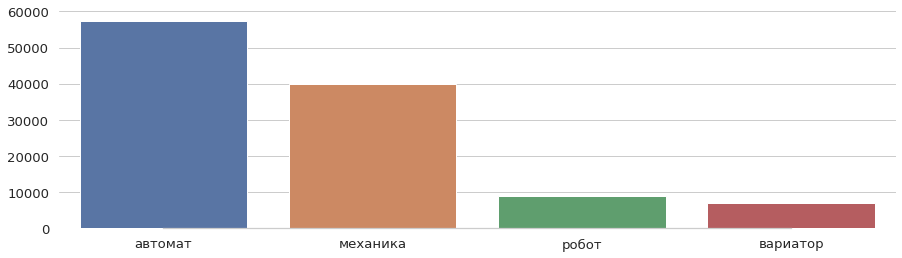

In [25]:
f, ax = plt.subplots(figsize=(15,4))
sns.countplot(x='transmission', data=df, order=df['transmission'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

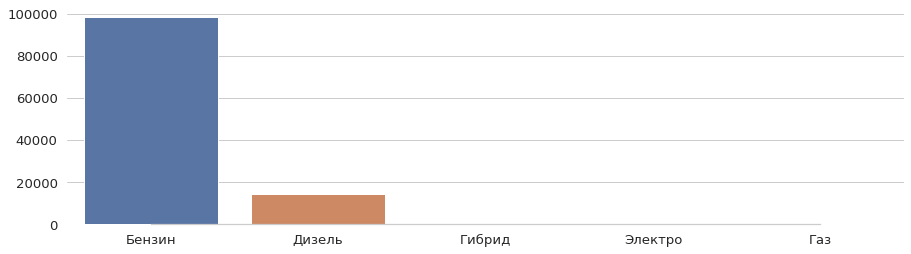

In [26]:
f, ax = plt.subplots(figsize=(15,4))
sns.countplot(x='gas', data=df, order=df['gas'].value_counts().index);
ax.set(ylabel="")
ax.set(xlabel="")
sns.despine(trim=True, left=True)

### Статистическая оценка по категориям

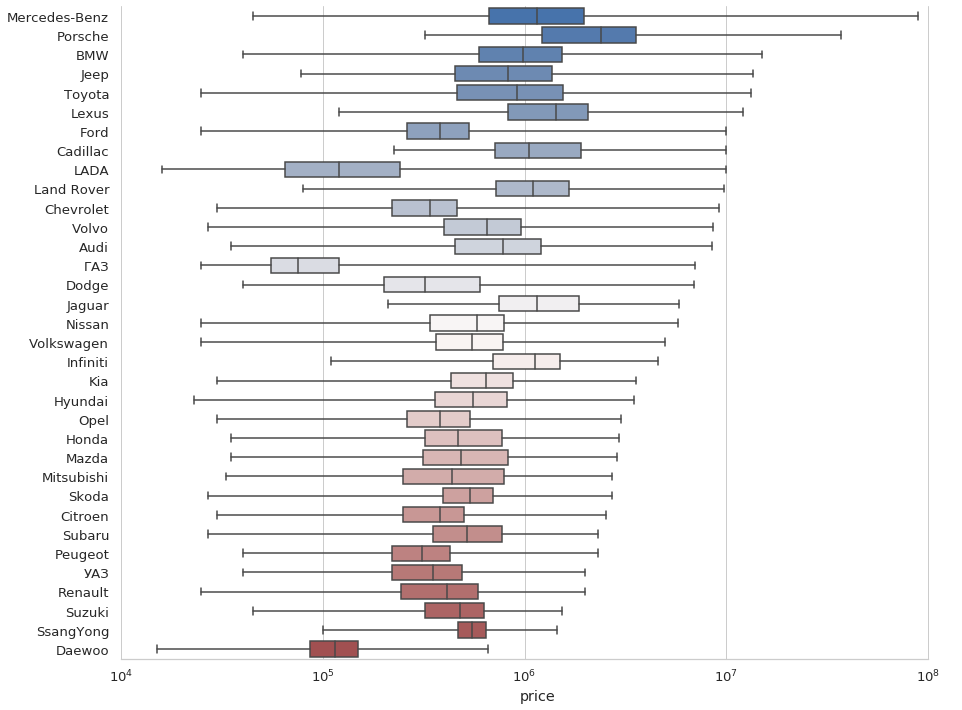

In [27]:
f, ax = plt.subplots(figsize=(15, 12))
ax.set_xscale("log")
sns.boxplot(x="price", y="manufacturer", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

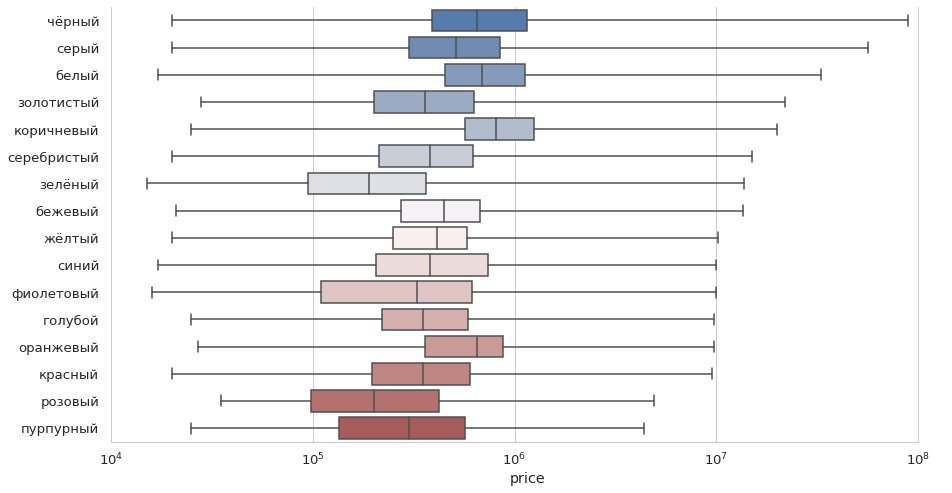

In [28]:
f, ax = plt.subplots(figsize=(15, 8))
ax.set_xscale("log")
sns.boxplot(x="price", y="color", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

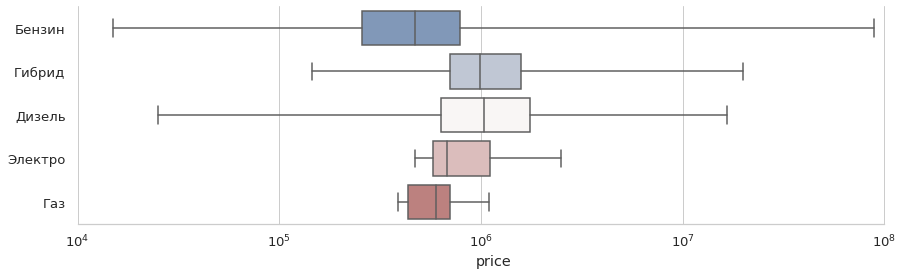

In [29]:
f, ax = plt.subplots(figsize=(15, 4))
ax.set_xscale("log")
sns.boxplot(x="price", y="gas", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

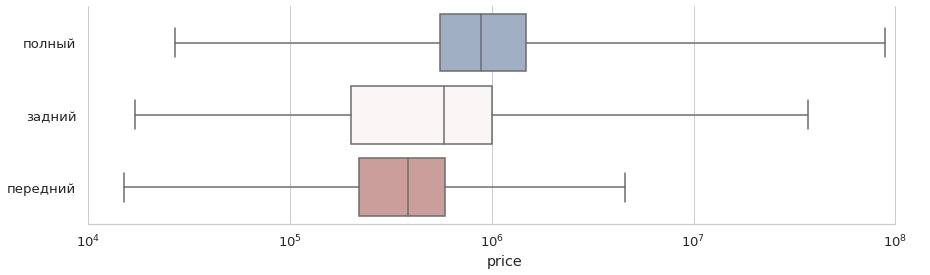

In [30]:
f, ax = plt.subplots(figsize=(15, 4))
ax.set_xscale("log")
sns.boxplot(x="price", y="drive", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

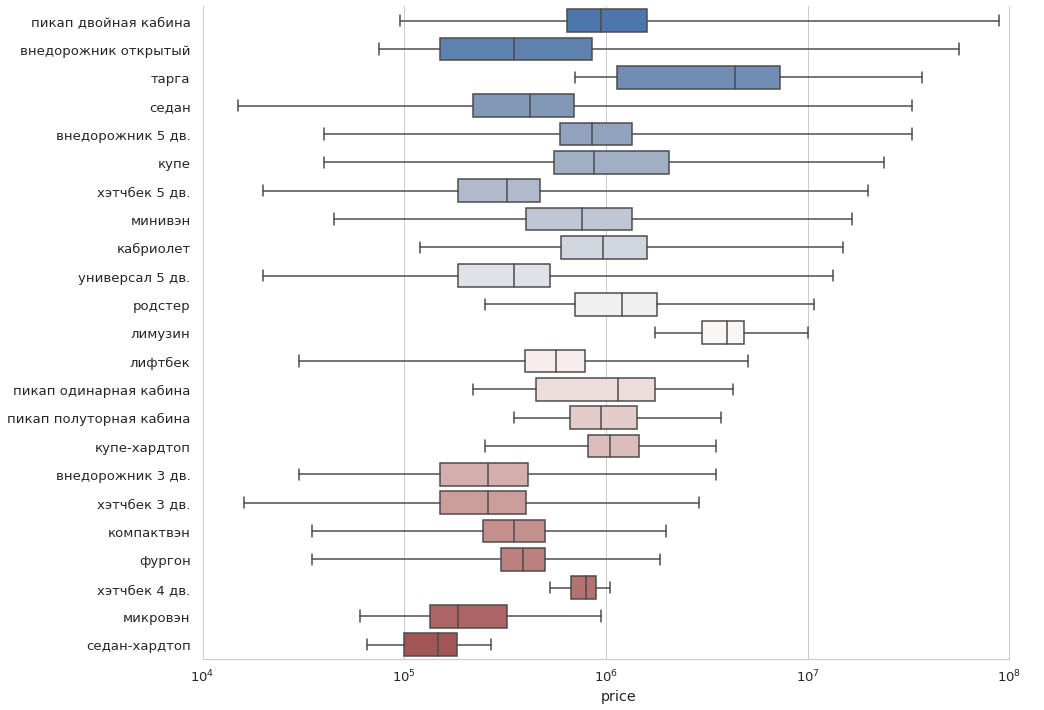

In [31]:
f, ax = plt.subplots(figsize=(15, 12))
ax.set_xscale("log")
sns.boxplot(x="price", y="body", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

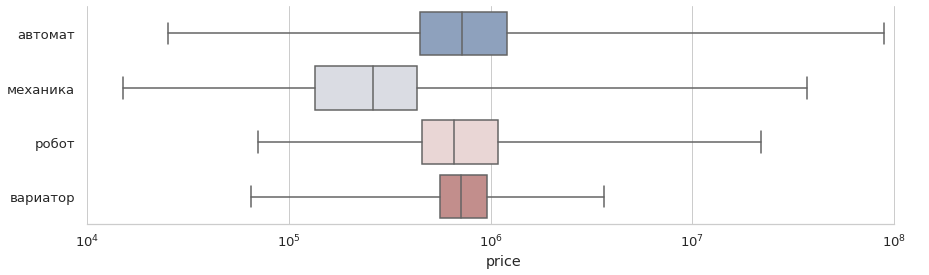

In [32]:
f, ax = plt.subplots(figsize=(15, 4))
ax.set_xscale("log")
sns.boxplot(x="price", y="transmission", data=df.sort_values('price', ascending=False),
            whis="range", palette="vlag")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

### Попарные корреляции и распределения признаков

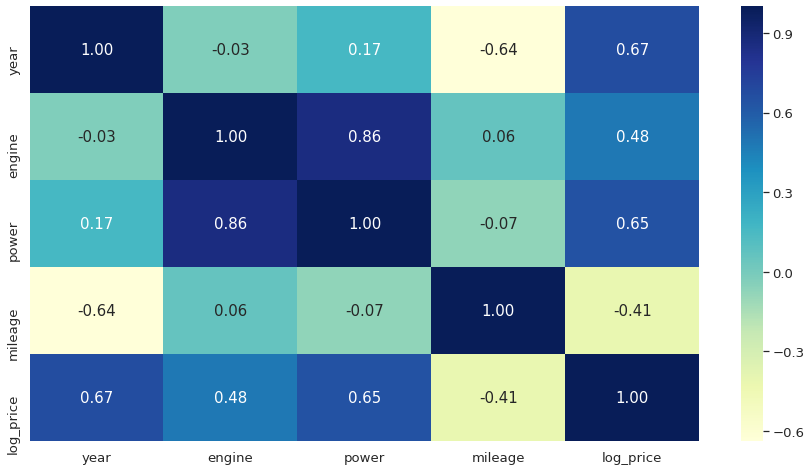

In [33]:
plt.figure(figsize=(15, 8))
df['log_price'] = df['price'].apply(lambda x: np.log(x))
corr_matrix=df[['year', 'engine', 'power', 'mileage', 'log_price']].corr()
sns.heatmap(corr_matrix,annot=True,fmt = ".2f",cbar = True, cmap="YlGnBu", annot_kws={"size":15});

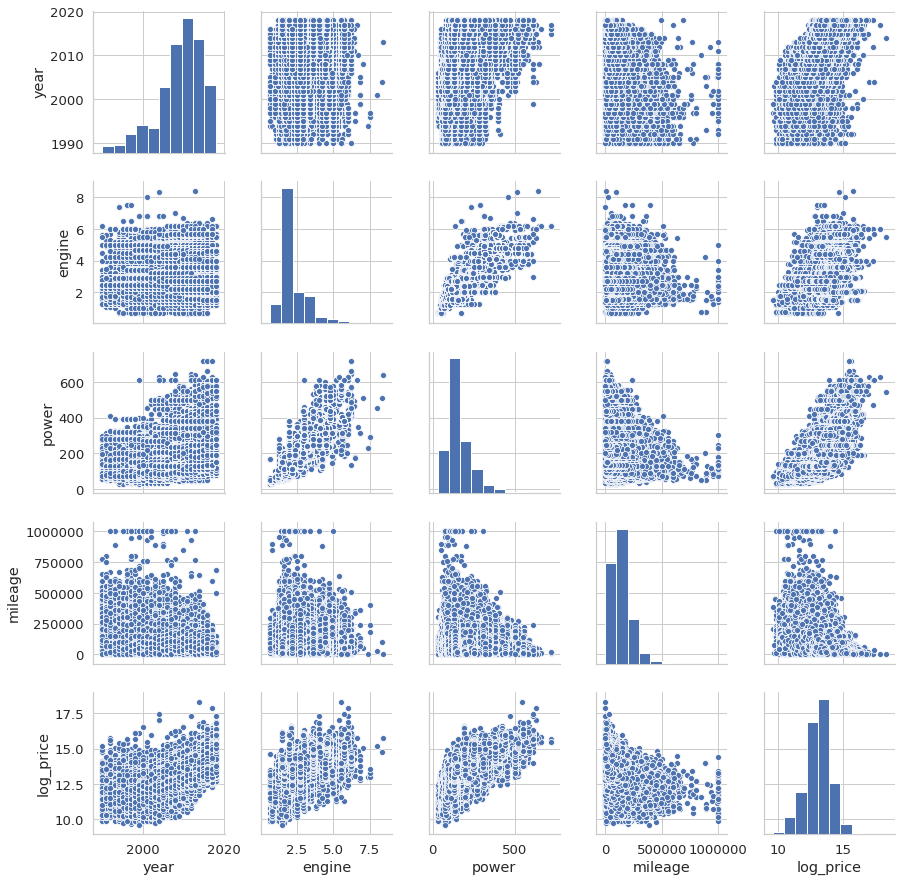

In [34]:
sns.pairplot(df[['year', 'engine', 'power', 'mileage', 'log_price']]);

Посмотрим на некоторые графики поближе

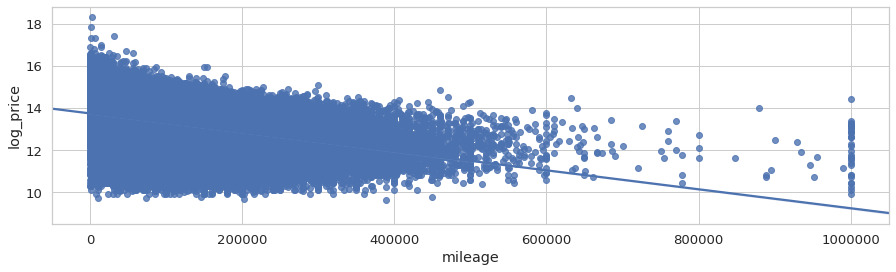

In [35]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='mileage', y='log_price', data=df, ax=ax);

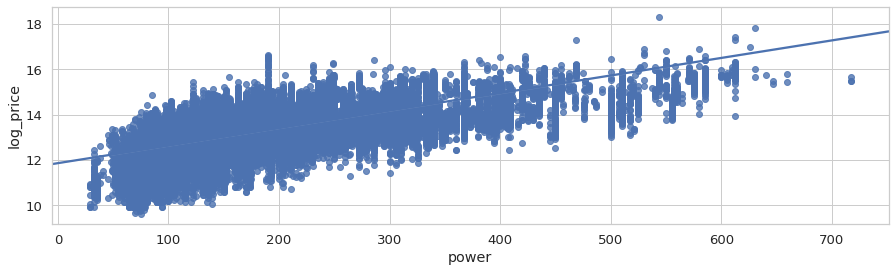

In [36]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='power', y='log_price', data=df, ax=ax);

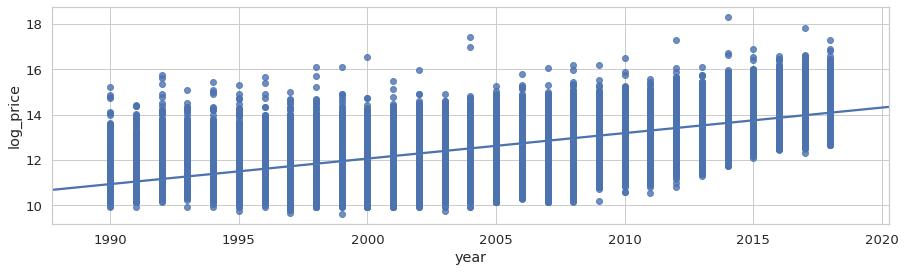

In [37]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='year', y='log_price', data=df, ax=ax);

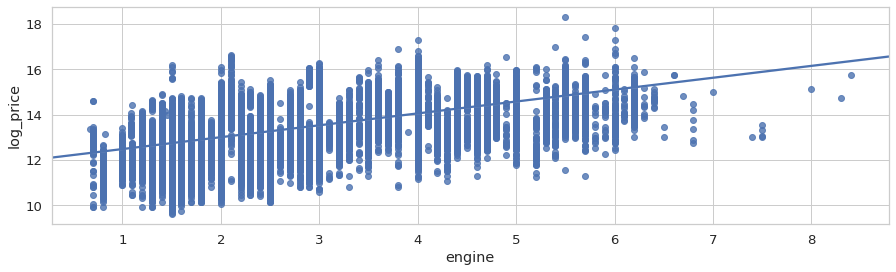

In [38]:
f, ax = plt.subplots(figsize=(15, 4))
sns.regplot(x='engine', y='log_price', data=df, ax=ax);

## Закономерности, особенности данных

### Распределения

* Распределение целевого признака визуально близко к логнормальному
* В распределении объявлений по году выпуска автомобиля явно наблюдается спад продаж новых автомобилей в 2009-2011 годах, вероятно, связанный с мировым финансовым кризисом
* Самые распространенные производители автомобилей: 
 - Lada 
 - Volkswagen
 - Mercedes-Benz 
 - BMW
 - Kia
* Самые распространенные формы кузова автомобилей: 
 - Седан 
 - Внедорожник 
 - Хэтчбек
* Самые распространенные цвета кузова автомобилей:
 - Черный
 - Белый
 - Серебристый
 - Серый 
 - Синий

### Категориальные признаки
 
* Наиболее дорогие автомобили были произведены маркой Mercedes-Benz, однако, если брать медианные показатели, то самый дорогой бренд Porsche
* Медианные данные премиальных брендов расположены довольно близко, исключение составляют Lexus и Porsche
* Наиболее дорогие автомобили, исходя из цвета кузова - черного цвета. Довольно неожиданно, что по медиане наиболее дорогой цвет - коричневый.
* Наиболее дорогие автомобили по типу двигателя, если брать медиану - дизельные, вероятно из-за того, что бюджетные модели редко бывают дизельными.
* Полный привод существенно повышает стоимость автомобиля на вторичном рынке. Задний привод так же повышает стоимость автомобиля.
* По форме кузова самыми дорогими автомобилями являются редкие варианты:
 - Тарга
 - Лимузин
 - Родстер
 - Кабриолет
 - Пикап
* Автомобили с механикой очевидно дешевле автомобилей с автоматом, роботом и вариатором

### Корреляции

* Цена уменьшается с увеличение пробега
* Цена растет с увеличением объема двигателя
* Цена на более старые автомобили - ниже
* Цена на более мощные автомобили - выше

## Выбор метрики

Выберем $R^2$ метрику, так как она наиболее наглядно показывает качество модели.
## $$ R^2(y,\hat{y})
= 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y})^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2} 
= 1 - \frac{MSE(model)}{MSE(baseline)}$$
## $$ MSE = {\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y})^2} $$



## Предобработка данных для тренировки модели

In [39]:
y = np.log(df['price'])
df.drop(['log_price'], axis=1, inplace=True)
X = df.drop(['price'], axis=1)

In [40]:
for cat_feature in X.columns[X.dtypes == 'object']:
    X[cat_feature] = X[cat_feature].astype('category')
    X[cat_feature].cat.set_categories(X[cat_feature].unique(), inplace=True)

In [41]:
X = pd.get_dummies(X, columns=X.columns[X.dtypes == 'category'])
X.shape

(113154, 941)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

## Baselines

In [44]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
lr = Ridge()
lr.fit(X_train_scaled, y_train);

In [46]:
y_preds_lr = lr.predict(X_test_scaled)
print('LinearRegression:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_lr))
print('\tR2: ', r2_score(y_test, y_preds_lr))

LinearRegression:
	MSE:  0.05613972920501582
	R2:  0.9385855491835554


In [47]:
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train, y_train);

In [48]:
y_preds_rf = rf.predict(X_test)
print('RandomForest:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_rf))
print('\tR2: ', r2_score(y_test, y_preds_rf))

RandomForest:
	MSE:  0.05267024283869919
	R2:  0.9423810181467979


In [54]:
print('Target range true: (%.2f, %.2f) ' % (y.min(), y.max()))
print('Target range linear regression: (%.2f, %.2f) ' % (y_preds_lr.min(), y_preds_lr.max()))
print('Target range random forest: (%.2f, %.2f) ' % (y_preds_rf.min(), y_preds_rf.max()))

Target range true: (9.62, 18.30) 
Target range linear regression: (9.71, 16.55) 
Target range random forest: (10.07, 16.48) 


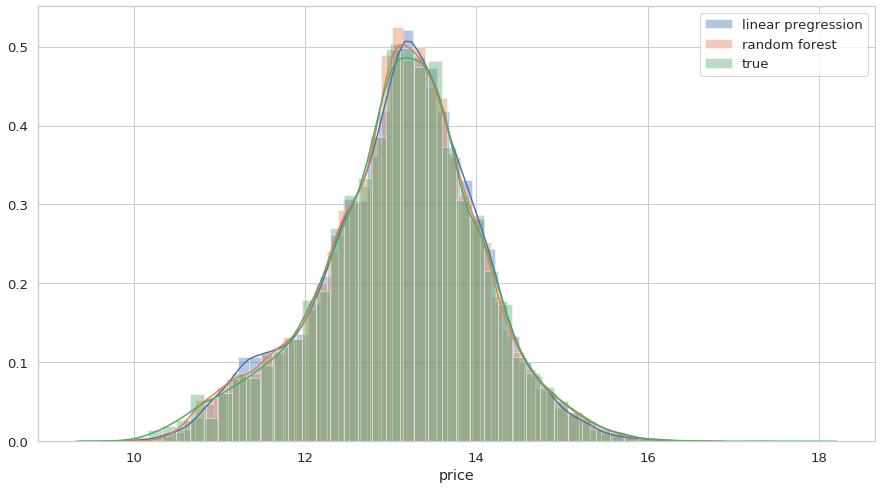

In [65]:
sns.distplot(y_preds_lr, label='linear regression');
sns.distplot(y_preds_rf, label='random forest');
sns.distplot(y_test, label='true');
plt.legend()
plt.show()

Я бы сказал, что обе модели неплохо справляются с задачей

## Feature Engineering

Посмотрим на важность признаков, чтобы понять на основе каких признаков стоит генерировать новые

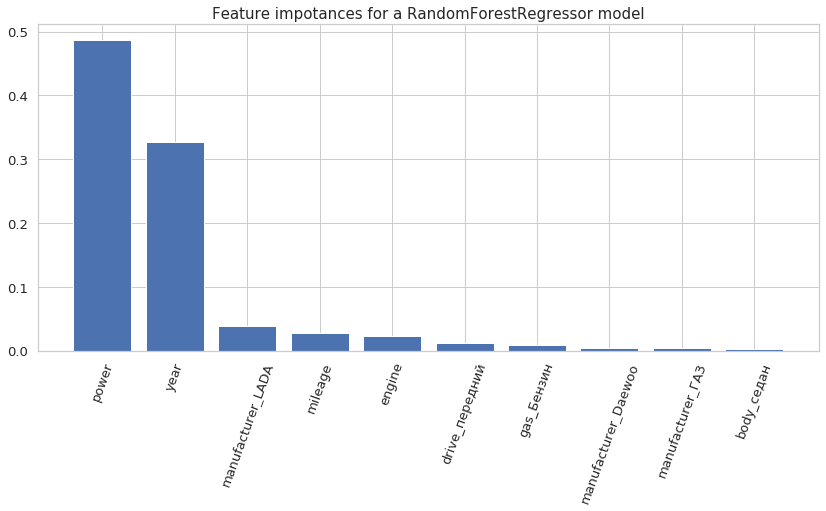

In [66]:
features = X_train.columns
importances = rf.feature_importances_
num_to_plot = 10
indices = np.argsort(importances)[::-1][:num_to_plot]
 
plt.figure(figsize=(14,6))
plt.title('Feature impotances for a RandomForestRegressor model', size=15)
bars = plt.bar(range(num_to_plot), importances[indices], align="center")b
ticks = plt.xticks(range(num_to_plot), features.values[indices[:]], rotation=70, size=13)

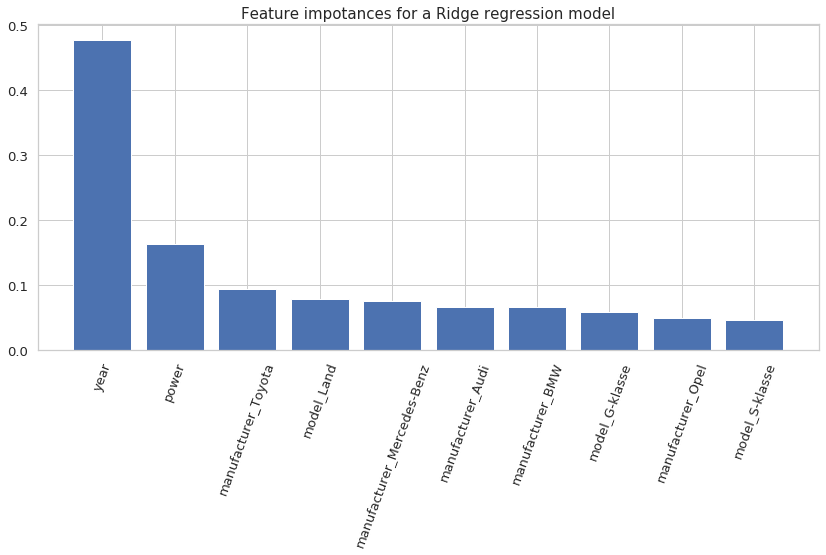

In [83]:
features = X_train.columns
importances = lr.coef_
num_to_plot = 10
indices = np.argsort(importances)[::-1][:num_to_plot]
 
plt.figure(figsize=(14,6))
plt.title('Feature impotances for a Ridge regression model', size=15)
bars = plt.bar(range(num_to_plot), importances[indices], align="center")
ticks = plt.xticks(range(num_to_plot), features.values[indices[:]], rotation=70, size=13)

Новые признаки, которые, возможно, будут полезны:
* mileage_per_year - средний пробег за год
* power_per_engine - удельная мощность двигателя
* manufacturer_group - принадлежность бренда производителя к локальной группе(японские, немецкие, американские и т.д.)
* tax_category - в какую категорию по налогу попадает автомобиль

In [67]:
new_feats_train = pd.DataFrame(index=X_train.index)
new_feats_test = pd.DataFrame(index=X_test.index)

In [68]:
new_feats_train['mileage_per_year'] = X_train['mileage'] / X_train['year']
new_feats_test['mileage_per_year'] = X_test['mileage'] / X_test['year']

In [69]:
new_feats_train['power_per_engine'] = X_train['power'] / X_train['engine']
new_feats_test['power_per_engine'] = X_test['power'] / X_test['engine']

In [70]:
df['manufacturer'].unique()

array(['LADA', 'Audi', 'BMW', 'Cadillac', 'Chevrolet', 'Citroen',
       'Daewoo', 'Dodge', 'Ford', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus', 'Mazda',
       'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Opel', 'Peugeot',
       'Porsche', 'Renault', 'Skoda', 'SsangYong', 'Subaru', 'Suzuki',
       'Toyota', 'Volkswagen', 'Volvo', 'ГАЗ', 'УАЗ'], dtype=object)

In [71]:
X_new = df.drop(['price'], axis=1)

In [72]:
X_new['manufacturer_group'] = \
X_new['manufacturer'].map({'LADA': 'Local', 'Audi': 'German', 'BMW': 'German',\
                            'Cadillac': 'American',
                            'Chevrolet': 'American', 'Citroen': 'French', 'Daewoo': 'Local', 'Dodge': 'American',\
                            'Ford': 'American', 'Honda': 'Japanese', 'Hyundai': 'Korean', 'Infiniti': 'Japanese',\
                            'Jaguar': 'British', 'Jeep': 'American', 'Kia': 'Korean', 'Land Rover': 'British',\
                            'Lexus': 'Japanese', 'Mazda': 'Japanese', 'Mercedes-Benz': 'German', \
                            'Mitsubishi': 'Japanese', 'Nissan': 'Japanese', 'Opel': 'German', 'Peugeot': 'French',\
                            'Porsche': 'German', 'Renault': 'French', 'Skoda': 'Czech', 'SsangYong': 'Korean',\
                            'Subaru': 'Japanese', 'Suzuki': 'Japanese', 'Toyota': 'Japanese', 'Volkswagen': 'German',\
                            'Volvo': 'Swedish', 'ГАЗ': 'Local', 'УАЗ': 'Local'})

In [73]:
for cat_feature in X_new.columns[X_new.dtypes == 'object']:
    X_new[cat_feature] = X_new[cat_feature].astype('category')
    X_new[cat_feature].cat.set_categories(X_new[cat_feature].unique(), inplace=True)

In [74]:
X_new = pd.get_dummies(X_new, columns=X_new.columns[X_new.dtypes == 'category'])
X_new.shape

(113154, 950)

In [75]:
def tax_categorizator(x):
    if x < 100:
        return 0
    elif (x >= 100) and (x < 150):
        return 1
    elif (x >= 150) and (x < 200):
        return 2
    elif (x >=200) and (x < 250):
        return 3
    elif (x >= 250):
        return 4

In [76]:
X_new['tax_category'] = X_new['power'].apply(tax_categorizator)

In [77]:
X_new.shape

(113154, 951)

In [78]:
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, \
                                                            shuffle=True, random_state=RANDOM_SEED)

In [79]:
rf.fit(X_new_train, y_train);

In [84]:
lr.fit(X_new_train, y_train);

In [80]:
y_preds_new_rf = rf.predict(X_new_test)
print('RandomForest with new features:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_new_rf))
print('\tR2: ', r2_score(y_test, y_preds_new_rf))
print('RandomForest baseline:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_rf))
print('\tR2: ', r2_score(y_test, y_preds_rf))

RandomForest with new features:
	MSE:  0.05179809582984779
	R2:  0.9433351094888528
RandomForest baseline:
	MSE:  0.05267024283869919
	R2:  0.9423810181467979


In [86]:
y_preds_new_lr = lr.predict(X_new_test)
print('Ridge with new features:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_new_lr))
print('\tR2: ', r2_score(y_test, y_preds_new_lr))
print('Ridge baseline:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_lr))
print('\tR2: ', r2_score(y_test, y_preds_lr))

Ridge with new features:
	MSE:  0.055765284935018346
	R2:  0.9389951751209958
Ridge baseline:
	MSE:  0.05613972920501582
	R2:  0.9385855491835554


Создание новых признаков улучшило модели на чуть менее чем одну тысячную, что, довольно, скромно. Вероятно для более значительного улучшения качества предсказаний нужно парсить больше информации, например добавить расход топлива, разгон до 100 км/ч, наличие люка, кондиционера и тд.

## Кривые валидации
Посмотрим на кривые валидации для определения пространства подбора гиперпараметров hyperopt'ом

In [87]:
def valid_curves_plot_rf(hyperparam, param_range):
    param_range = param_range
    train_scores, test_scores = validation_curve(RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1,), 
                                X_new_train, y_train, param_name=hyperparam, param_range=param_range, 
                                cv=kf, n_jobs=-1, scoring='r2')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(9,6))
    plt.title('Validation curves for a RandomForestRegressor model')
    plt.xlabel(hyperparam)
    plt.ylabel('R2')
    plt.ylim(0.8, 1.0)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, \
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, train_scores_mean, label='Training error', color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, \
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(param_range, test_scores_mean, label='Validation error', color="g")

    plt.legend(loc="best")
    plt.xticks(param_range)
    plt.show()

In [108]:
def valid_curves_plot_ridge(hyperparam, param_range):
    param_range = param_range
    train_scores, test_scores = validation_curve(Ridge(random_state=RANDOM_SEED), 
                                X_new_train, y_train, param_name=hyperparam, param_range=param_range, 
                                cv=kf, n_jobs=-1, scoring='r2')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(9,6))
    plt.title('Validation curves for a Ridge redression model')
    plt.xlabel(hyperparam)
    plt.ylabel('R2')
    plt.ylim(0.935, 0.945)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, \
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, train_scores_mean, label='Training error', color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, \
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(param_range, test_scores_mean, label='Validation error', color="g")

    plt.legend(loc="best")
    plt.xticks(param_range)
    plt.show()

In [88]:
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

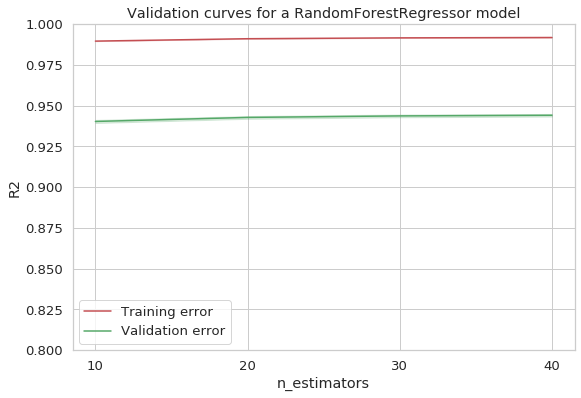

CPU times: user 304 ms, sys: 57 ms, total: 361 ms
Wall time: 1min 36s


In [91]:
%%time
valid_curves_plot_rf(hyperparam='n_estimators', param_range=[10, 20, 30, 40])

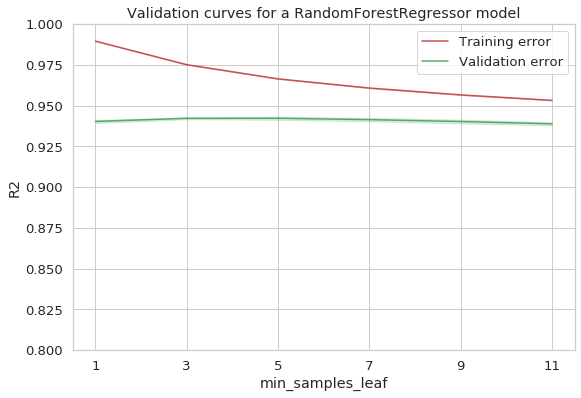

CPU times: user 364 ms, sys: 36 ms, total: 400 ms
Wall time: 47.5 s


In [94]:
%%time
valid_curves_plot_rf(hyperparam='min_samples_leaf', param_range=[1, 3, 5, 7, 9, 11])

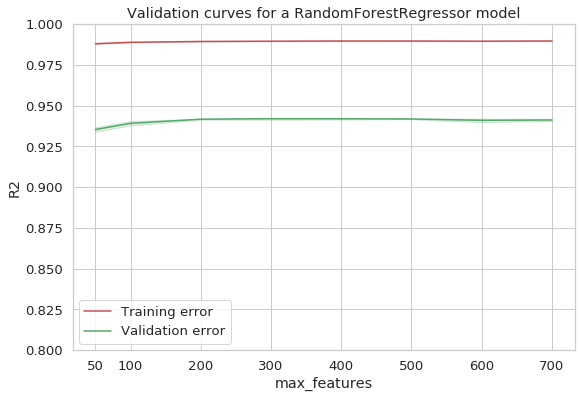

CPU times: user 352 ms, sys: 56.5 ms, total: 408 ms
Wall time: 48.4 s


In [95]:
%%time
valid_curves_plot_rf(hyperparam='max_features', param_range=[50, 100, 200, 300, 400])

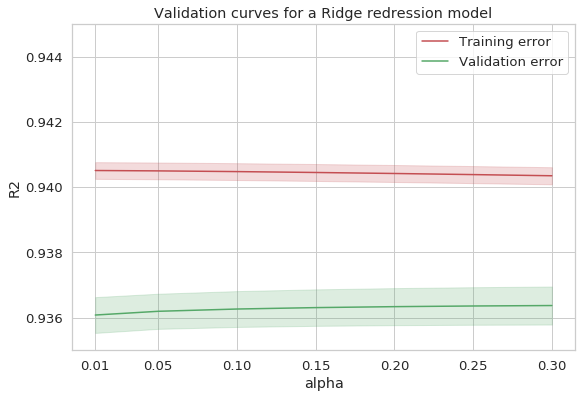

CPU times: user 324 ms, sys: 33.7 ms, total: 358 ms
Wall time: 15.2 s


In [110]:
%%time
valid_curves_plot_ridge(hyperparam='alpha', param_range=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

## Подбор  гиперпараметров
Для подбора параметров будем использовать hyperopt. GridSearch может пропускать оптимальные значения, а RandomSearch дает нестабильные результаты, к тому же, с ним можно довольно долго подбирать параметры.

In [112]:
def acc_model(params):
    clf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, **params)
    return cross_val_score(clf, X_new_train, y_train).mean()

param_space = {
    'min_samples_leaf': hp.choice('min_samples_leaf', range(3,7)),
    'n_estimators': hp.choice('n_estimators', range(20,50)),
    'max_features': hp.choice('max_features', range(100, 400))
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

new best:                                           
0.9469822043948216                                  
{'max_features': 361, 'min_samples_leaf': 3, 'n_estimators': 42}
new best:                                                                     
0.9469822043948216                                                            
{'max_features': 181, 'min_samples_leaf': 4, 'n_estimators': 30}              
new best:                                                                     
0.9469822043948216                                                            
{'max_features': 104, 'min_samples_leaf': 3, 'n_estimators': 24}              
new best:                                                                     
0.9469822043948216                                                            
{'max_features': 207, 'min_samples_leaf': 3, 'n_estimators': 46}              
new best:                                                                     
0.9469822043948216                     

{'max_features': 204, 'min_samples_leaf': 3, 'n_estimators': 25}              
new best:                                                                     
0.947013517615629                                                             
{'max_features': 137, 'min_samples_leaf': 5, 'n_estimators': 28}              
new best:                                                                     
0.947013517615629                                                             
{'max_features': 366, 'min_samples_leaf': 3, 'n_estimators': 38}              
new best:                                                                     
0.947013517615629                                                             
{'max_features': 170, 'min_samples_leaf': 3, 'n_estimators': 29}              
new best:                                                                     
0.947013517615629                                                             
{'max_features': 384, 'min_samples_leaf': 6, 'n_esti

In [113]:
rf_best = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=18, max_features=169, min_samples_leaf=6,\
                               n_estimators=45)

In [120]:
def acc_model_ridge(params):
    clf = Ridge(random_state=RANDOM_SEED, **params)
    return cross_val_score(clf, X_new_train, y_train).mean()

param_space = {
    'alpha': hp.uniform('alpha', 0, 0.3)
}

best = 0
def f(params):
    global best
    acc = acc_model_ridge(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

new best:                                           
0.9362209039089021                                  
{'alpha': 0.13335774755042004}                      
new best:                                                                     
0.936305255222821                                                             
{'alpha': 0.24339758622566166}                                                
new best:                                                                     
0.936305255222821                                                            
{'alpha': 0.009744569184178676}                                              
new best:                                                                    
0.9363254487200162                                                           
{'alpha': 0.28521594287232405}                                               
new best:                                                                     
0.9363254487200162                                      

0.9363314492711242                                                             
{'alpha': 0.29933564994693435}                                                 
new best:                                                                      
0.9363314492711242                                                             
{'alpha': 0.012117763340834059}                                                
new best:                                                                      
0.9363314492711242                                                             
{'alpha': 0.05935634801434547}                                                 
new best:                                                                      
0.9363314492711242                                                             
{'alpha': 0.2709726107974325}                                                  
new best:                                                                      
0.9363314492711242                      

In [121]:
lr_best=Ridge(random_state=RANDOM_SEED, alpha=0.3)

## Оценка моделей

In [122]:
rf_best.fit(X_new_train, y_train);

In [123]:
lr_best.fit(X_new_train, y_train);

In [124]:
y_preds_rf_best = rf_best.predict(X_new_test)
print('RandomForest best hyperparams:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_rf_best))
print('\tR2: ', r2_score(y_test, y_preds_rf_best))

RandomForest best hyperparams:
	MSE:  0.050414658516252424
	R2:  0.9448485304486006


In [126]:
y_preds_lr_best = lr_best.predict(X_new_test)
print('Ridge regression best hyperparams:')
print('\tMSE: ', mean_squared_error(y_test, y_preds_lr_best))
print('\tR2: ', r2_score(y_test, y_preds_lr_best))

Ridge regression best hyperparams:
	MSE:  0.05568662993315634
	R2:  0.9390812203123733


In [127]:
y_test_preds_rf_best = pd.DataFrame({'y_true': np.exp(y_test),'y_preds': np.exp(y_preds_rf_best)})
y_test_preds_rf_best['diff'] = np.absolute(y_test_preds_rf_best['y_true'] - y_test_preds_rf_best['y_preds'])
y_test_preds_rf_best.head(20).T

,58324,95293,74794,35043,43623,23821,35365,92485,26211,6766,12104,59030,68810,52369,4979,44203,40533,107596,9085,101884
y_true,150000.00,699000.00,350000.0,490000.00,460000.00,309000.00,497000.00,675000.00,1.25e+06,185000.00,780000.00,315000.00,6.05e+06,560000.00,145000.00,620000.00,650000.00,540000.0,345000.00,1.30e+06
y_preds,132160.63,648467.27,457218.6,501148.77,495363.87,372771.41,438995.34,734825.46,8.44e+05,203357.33,646808.15,334379.01,7.61e+06,476802.18,106837.25,576230.46,589990.65,505477.0,349216.32,1.22e+06
diff,17839.37,50532.73,107218.6,11148.77,35363.87,63771.41,58004.66,59825.46,4.06e+05,18357.33,133191.85,19379.01,1.56e+06,83197.82,38162.75,43769.54,60009.35,34523.0,4216.32,8.15e+04


## Выводы

Подбор гиперпараметров и генерирование новых признаков помогли улучшить качество предсказаний, однако незначительно - речь идет о третьем знаке после запятой по нашей метрике. Слуйчайный лес выдает отличный результат "из коробки" и в очередной раз доказал это, линейная регрессия так же дает неплохие результаты. С учетом хороших предсказаний случайного леса имеет смысл попробовать градентный бустинг для решения этой задачи. Так же, для улучшения прогностической силы модели необходимо расширить выборку, распарсить больше различных признаков, которые могут быть связаны с ценой на автомобиль. Совсем ничего не было предпринято для борьбы с выбросами. Думаю, что можно было бы кластеризовать автомобили по маркам и моделям и удалить выборсы на определенном расстоянии от центра масс. Таким образом можно было бы отсечь некоторые мошеннические объявления и опечатки.

Что касается применения модели на практике: видно, что по многим автомобилям разброс между предсказанием и реально ценой находятся довольно близко. Так, что для массовых автомобилей модель работает довольно адекватно. Предсказание же цены для эксклюзивных и редких автомобилей не может быть решено методами машинного обучения из-за ограничений в количестве доступных данных и множества сложноучитываемых факторов, влияющих на цену.

## XGBoost

In [ ]:
model = xgb.XGBRegressor()
model.fit(X_new_train, y_train)

In [ ]:
output = model.predict(data=X_new_test)

In [ ]:
print('XGB baseline:')
print('\tMSE: ', mean_squared_error(y_test, output))
print('\tR2: ', r2_score(y_test, output))

In [ ]:
def acc_model(params):
    clf = xgb.XGBRegressor(**params)
    return cross_val_score(clf, X_new_train, y_train).mean()

param_space = {
    'tree_method': 'gpu_hist',
    'random_state': RANDOM_SEED,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'max_depth': hp.choice('max_depth', range(1, 14)),
    'learning_rate': hp.quniform('learning_rate', 0.025, 1, 0.025),
    'n_estimators': hp.choice('n_estimators', range(10, 500))
}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

In [ ]:
model = xgb.XGBRegressor(eval_metric='rmse', learning_rate=0.125, max_depth=11, n_estimators=175,
                         objective='reg:squarederror',random_state=RANDOM_SEED, tree_method='gpu_hist')
model.fit(X_new_train, y_train)

In [ ]:
output = model.predict(data=X_new_test)

In [ ]:
print('XGB best:')
print('\tMSE: ', mean_squared_error(y_test, output))
print('\tR2: ', r2_score(y_test, output))